<font color='purple' size="+3">Traffic Prediction Model</font>


In [386]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

from sklearn.linear_model import Ridge, LinearRegression
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error,r2_score, mean_absolute_percentage_error

In [387]:
df = pd.read_csv(r"C:\Users\Delll\Downloads\Metro_Interstate_Traffic_Volume.csv.gz")

In [388]:
df.shape

(48204, 9)

In [389]:
df.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,None,291.72,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,None,293.17,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,None,293.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,None,294.14,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,None,293.10,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770


In [390]:
df.describe(include='all')

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
count,48204,48204.000000,48204.000000,48204.000000,48204.000000,48204,48204,48204,48204.000000
unique,12,NaN,NaN,NaN,NaN,11,38,40575,NaN
top,None,NaN,NaN,NaN,NaN,Clouds,sky is clear,2013-05-19 10:00:00,NaN
freq,48143,NaN,NaN,NaN,NaN,15164,11665,6,NaN
mean,NaN,281.205870,0.334264,0.000222,49.362231,NaN,NaN,NaN,3259.818355
std,NaN,13.338232,44.789133,0.008168,39.015750,NaN,NaN,NaN,1986.860670
min,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,272.160000,0.000000,0.000000,1.000000,NaN,NaN,NaN,1193.000000
50%,NaN,282.450000,0.000000,0.000000,64.000000,NaN,NaN,NaN,3380.000000
75%,NaN,291.806000,0.000000,0.000000,90.000000,NaN,NaN,NaN,4933.000000


In [391]:
def data_profiling(df):
    data_profile = []
    columns = df.columns
    for col in columns:
        dtype = df[col]. dtype
        nunique = df[col].nunique()
        null = df[col].isnull().sum()
        duplicates = df[col].duplicated().sum()
        data_profile.append([col, dtype, nunique, null, duplicates])
    data_profile_finding = pd.DataFrame(data_profile)
    data_profile_finding.columns = ['column','dtype', 'nunique', 'null', 'duplicates']
    return data_profile_finding

In [392]:
data_profiling(df)

,column,dtype,nunique,null,duplicates
0,holiday,object,12,0,48192
1,temp,float64,5843,0,42361
2,rain_1h,float64,372,0,47832
3,snow_1h,float64,12,0,48192
4,clouds_all,int64,60,0,48144
5,weather_main,object,11,0,48193
6,weather_description,object,38,0,48166
7,date_time,object,40575,0,7629
8,traffic_volume,int64,6704,0,41500


In [393]:
print(df['holiday'].unique())

['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']


In [394]:
print(df['weather_main'].unique())

['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke']


In [395]:
print(df['weather_description'].unique())

['scattered clouds' 'broken clouds' 'overcast clouds' 'sky is clear'
 'few clouds' 'light rain' 'light intensity drizzle' 'mist' 'haze' 'fog'
 'proximity shower rain' 'drizzle' 'moderate rain' 'heavy intensity rain'
 'proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'heavy snow' 'heavy intensity drizzle'
 'snow' 'thunderstorm with heavy rain' 'freezing rain' 'shower snow'
 'light rain and snow' 'light intensity shower rain' 'SQUALLS'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'Sky is Clear' 'very heavy rain'
 'thunderstorm with light drizzle' 'light snow'
 'thunderstorm with drizzle' 'smoke' 'shower drizzle' 'light shower snow'
 'sleet']


In [396]:
df['weather_description'] = df['weather_description'].replace('Sky is Clear', 'sky is clear')

In [397]:
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [398]:
#convert date_time column to datetime
df['date_time'] = pd.to_datetime(df['date_time'])

In [399]:
df['hour'] = df['date_time'].dt.hour
df['day'] = df['date_time']. dt.day
df['month'] = df['date_time'].dt.month
df['Year'] = df['date_time'].dt.year
df['day_of_week'] = df['date_time'].dt.day_name()
df['week_day'] = df['date_time'].dt.weekday
df['is_weekend'] = df['week_day'] >= 5

In [400]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,day,month,Year,day_of_week,week_day,is_weekend
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,9,2,10,2012,Tuesday,1,False
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,2,10,2012,Tuesday,1,False
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,11,2,10,2012,Tuesday,1,False
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,12,2,10,2012,Tuesday,1,False
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,13,2,10,2012,Tuesday,1,False


**Data Visualization**

Text(0.5, 1.0, 'Distribution of Traffic Volume')

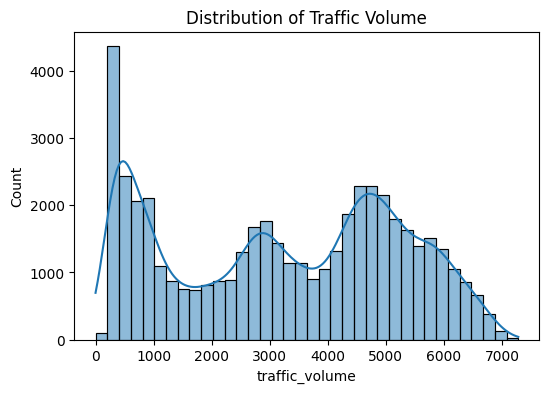

In [401]:
#Distribution of Traffic Volume
plt.figure(figsize= (6,4))
sns.histplot(df['traffic_volume'], kde=True)
plt.title('Distribution of Traffic Volume')

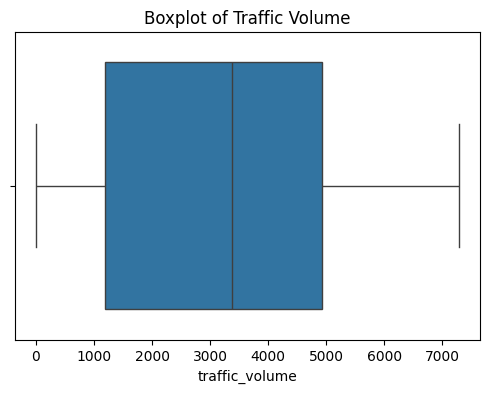

In [402]:
plt.figure(figsize=(6,4))
sns.boxplot(x =df['traffic_volume'])
plt.title('Boxplot of Traffic Volume')
plt.show()

**There are no outliers in the traffic volume feature**

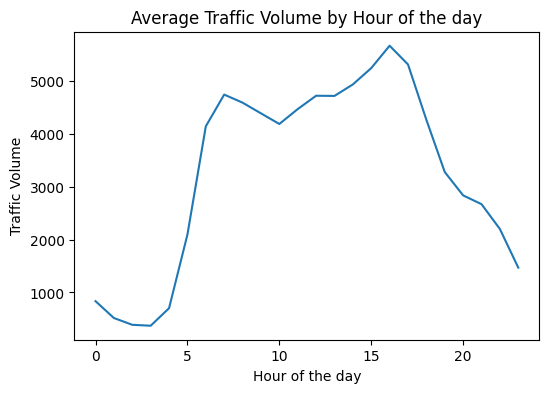

In [403]:
#Plotting traffic volume by time
plt.figure(figsize = (6,4))
hourly_average = df.groupby('hour')['traffic_volume'].mean()
sns.lineplot(x=hourly_average.index, y = hourly_average.values)
plt.title('Average Traffic Volume by Hour of the day')
plt.xlabel('Hour of the day')
plt.ylabel('Traffic Volume')
plt.show()

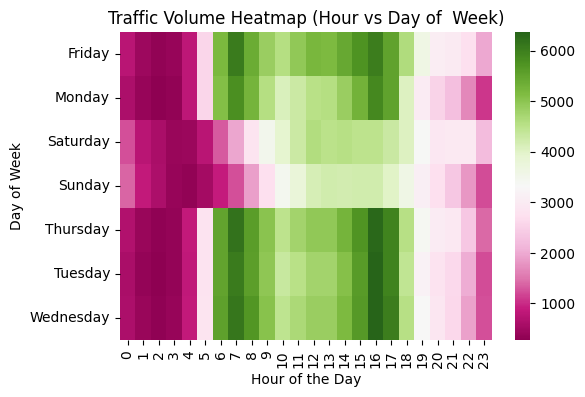

In [404]:
df_pivot = df.pivot_table(values='traffic_volume', index='day_of_week', columns = 'hour', aggfunc= 'mean')

plt.figure(figsize = (6,4))
sns.heatmap(df_pivot, cmap='PiYG')
plt.title('Traffic Volume Heatmap (Hour vs Day of  Week)')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of Week')
plt.show()


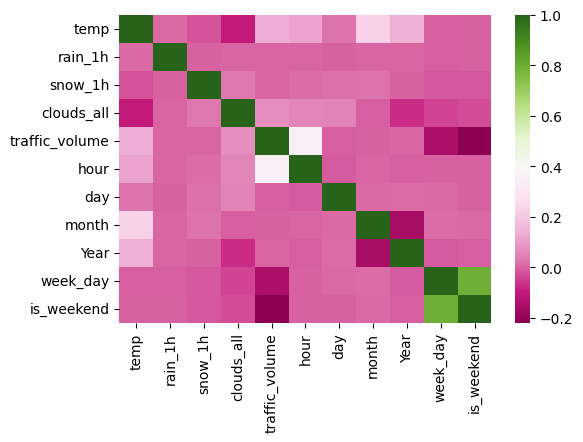

In [405]:

#Correlation heatmap between the variables
corr = df.corr()

plt.figure(figsize=(6,4))
#sns.heatmap(corr, annot=True,cmap="PiYG")
sns.heatmap(corr, annot=False,cmap="PiYG")
plt.show()

In [406]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume', 'hour', 'day',
       'month', 'Year', 'day_of_week', 'week_day', 'is_weekend'],
      dtype='object')

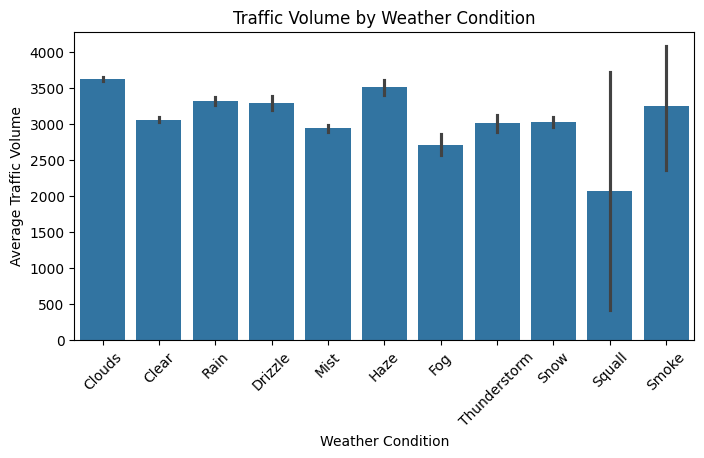

In [407]:
plt.figure(figsize=(8,4))
sns.barplot(x= 'weather_main', y='traffic_volume', data=df)
plt.title('Traffic Volume by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Traffic Volume')
plt.xticks(rotation=45)
plt.show()

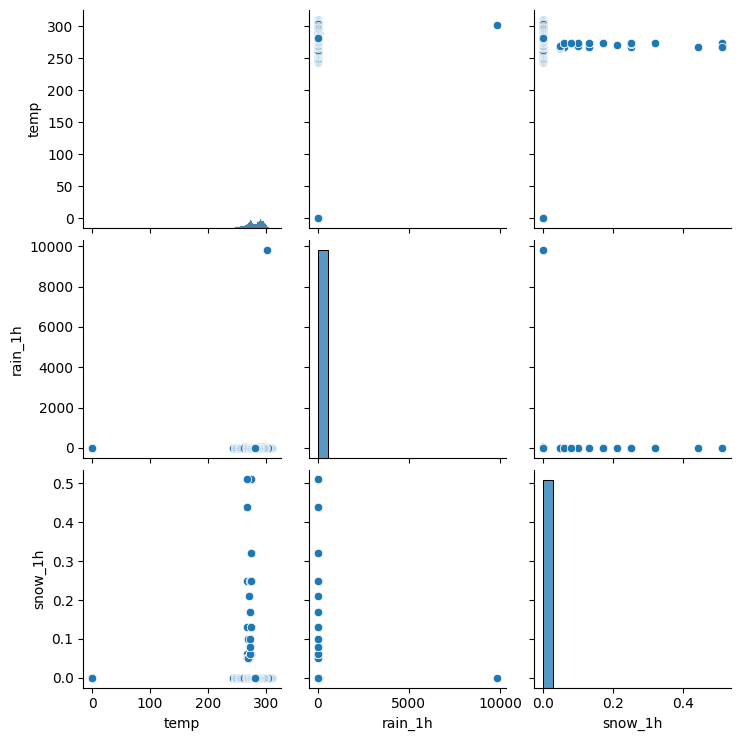

In [408]:
sns.pairplot(df[['holiday', 'temp', 'rain_1h', 'snow_1h']])
plt.show()

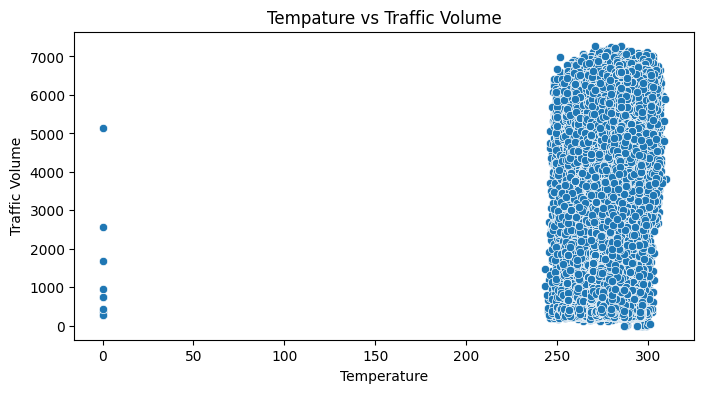

In [409]:

plt.figure(figsize=(8,4))
sns.scatterplot(x= 'temp', y='traffic_volume', data=df)
plt.title('Tempature vs Traffic Volume')
plt.xlabel('Temperature')
plt.ylabel('Traffic Volume')
plt.show()

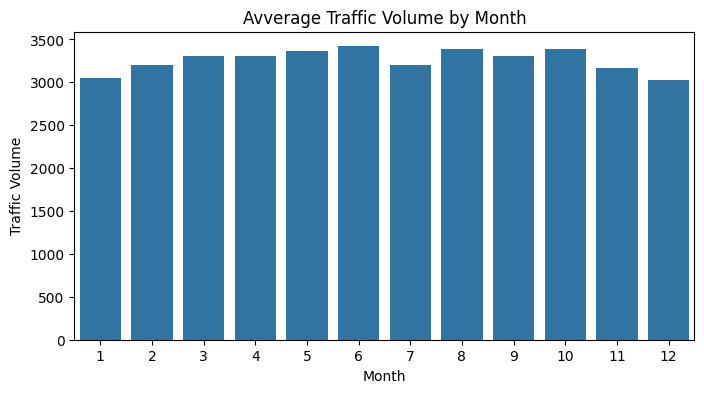

In [410]:
plt.figure(figsize=(8,4))
monthly_average = df.groupby('month')['traffic_volume'].mean()
sns.barplot(x= monthly_average.index, y=monthly_average.values)
plt.title('Avverage Traffic Volume by Month')
plt.xlabel('Month')
plt.ylabel('Traffic Volume')
plt.show()

**Feature Engineerin**

In [411]:
df['rush_hour'] = df['hour'].apply(lambda x: 1 if (x >= 7 and x <=9) or (x >= 16 and x <=18) else 0)

In [412]:
df['temperature_category'] = pd.qcut(df['temp'], q=4, labels=['Very Cold', 'Cold', 'Warm', 'Hot'])

print(df[['temp', 'temperature_category']])

         temp temperature_category
0      288.28                 Warm
1      289.36                 Warm
2      289.58                 Warm
3      290.13                 Warm
4      291.14                 Warm
...       ...                  ...
48199  283.45                 Warm
48200  282.76                 Warm
48201  282.73                 Warm
48202  282.09                 Cold
48203  282.12                 Cold

[48204 rows x 2 columns]


In [413]:
df['weather_time_interaction'] = df['weather_main'] + '_' + df['hour'].astype(str)

print(df[['weather_main', 'hour', 'weather_time_interaction']])

       weather_main  hour weather_time_interaction
0            Clouds     9                 Clouds_9
1            Clouds    10                Clouds_10
2            Clouds    11                Clouds_11
3            Clouds    12                Clouds_12
4            Clouds    13                Clouds_13
...             ...   ...                      ...
48199        Clouds    19                Clouds_19
48200        Clouds    20                Clouds_20
48201  Thunderstorm    21          Thunderstorm_21
48202        Clouds    22                Clouds_22
48203        Clouds    23                Clouds_23

[48204 rows x 3 columns]


In [414]:
df_copy =df.copy()

In [415]:
df_copy = pd.get_dummies(df_copy, columns=['holiday', 'weather_main', 'weather_description', 'temperature_category'])

In [416]:

label_encoder = LabelEncoder()
df_copy['day_of_week'] = label_encoder.fit_transform(df_copy['day_of_week'])
df_copy['Year'] = label_encoder.fit_transform(df_copy['Year'])
df_copy['weather_time_interaction'] = label_encoder.fit_transform(df_copy['weather_time_interaction'])

In [417]:
X = df_copy.drop(['traffic_volume', 'date_time'], axis=1) 
y = df_copy.traffic_volume

In [418]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size= 0.3, random_state= 120)

In [419]:
print("X_train : ",X_train.shape)
print("y_train : ",y_train.shape)
print("X_test : ",X_test.shape)
print("y_test : ",y_test.shape)

X_train :  (33742, 77)
y_train :  (33742,)
X_test :  (14462, 77)
y_test :  (14462,)


In [420]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [421]:
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'Ridge': Ridge(alpha = 0.5, random_state = 42),
    'Linear Regression': LinearRegression().fit(X_train, y_train),
    'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    'Light GBM': lgb.LGBMRegressor(random_state = 42, force_col_wise = True, verbosity =  -1 )
}


# Train and evaluate models
results = []
for name, model in models.items():
    print("Training", name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R-squared (R^2)': r2,
        'MAPE': mape
    })

# Create DataFrame from results
results_df = pd.DataFrame(results)


Training Random Forest Regressor
Training Ridge
Training Linear Regression
Training XGBoost Regressor
Training Light GBM


In [422]:
results_df.sort_values(by="RMSE", ascending=False)

,Model,RMSE,MAE,R-squared (R^2),MAPE
2,Linear Regression,3.745854e+14,4.405059e+12,-3.599799e+22,9.905849e+14
1,Ridge,1.516341e+03,1.283415e+03,4.101115e-01,9.698938e+14
0,Random Forest Regressor,3.901747e+02,2.170141e+02,9.609434e-01,7.852245e+14
4,Light GBM,3.580656e+02,2.230374e+02,9.671071e-01,4.104640e+14
3,XGBoost Regressor,3.475240e+02,2.135770e+02,9.690154e-01,4.419820e+14


<AxesSubplot: xlabel='traffic_volume', ylabel='Count'>

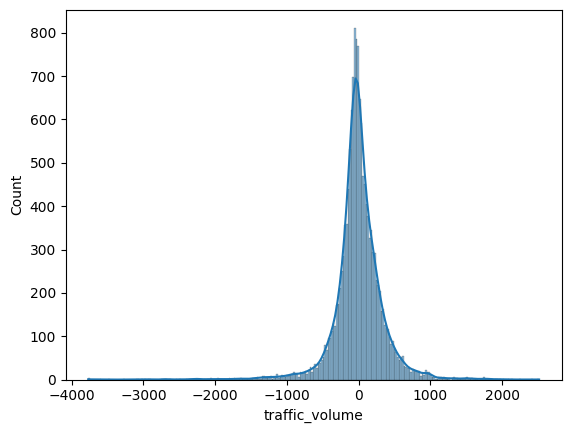

In [423]:
residuals = y_test- y_pred
sns.histplot(residuals,kde=True)

In [424]:
from sklearn.model_selection import RandomizedSearchCV
lgb_param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'min_data_in_leaf': [20, 50, 100],
    'feature_fraction': [0.6, 0.8, 1.0],
    'max_depth': [-1, 3,5,7]
}

lgb_model = lgb.LGBMRegressor()
lgb_random_search = RandomizedSearchCV(lgb_model, param_distributions= lgb_param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=5, verbose =1, n_jobs =-1)
lgb_random_search.fit(X_train, y_train)

print(f'Best Prameters for LightGBM: {lgb_random_search.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 984

In [365]:
from xgboost import XGBRegressor
xgb_param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1,0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3,5,7,9]
}

xgb = XGBRegressor()
xgb_random_search = RandomizedSearchCV(xgb, param_distributions= xgb_param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=5, verbose =1, n_jobs =-1)
xgb_random_search.fit(X_train, y_train)

print(f'Best Prameters for XGBoost: {xgb_random_search.best_params_}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Prameters for XGBoost: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [366]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
print(f'Average RMSE: {-cv_scores.mean()}')

Average RMSE: 354.4451137809377


In [377]:
new_models = {
    'XGBoost Regressor': XGBRegressor(subsample= 0.8, n_estimators=1000, max_depth=  9, learning_rate= 0.1, colsample_bytree= 0.8),
    'Light GBM': lgb.LGBMRegressor(num_leaves=100, n_estimators= 1000, min_data_in_leaf= 20, max_depth= -1, learning_rate= 0.01, feature_fraction= 0.8 )
}


# Train and evaluate models
new_results = []
for name, model in new_models.items():
    print("Training", name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    new_results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R-squared (R^2)': r2,
        'MAPE': mape
    })

new_result_df = pd.DataFrame(new_results)

Training XGBoost Regressor
Training Light GBM
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 984
[LightGBM] [Info] Number of data points in the train set: 33742, number of used features: 51
[LightGBM] [Info] Start training from score 3245.148865
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

In [378]:
new_result_df.sort_values(by="RMSE", ascending=True)

,Model,RMSE,MAE,R-squared (R^2),MAPE
0,XGBoost Regressor,277.086918,168.260296,0.980303,3.074145e+14
1,Light GBM,310.428492,192.785673,0.975277,4.764848e+14


In [383]:
lgb_best_model =  lgb.LGBMRegressor(num_leaves=100, n_estimators= 1000, min_data_in_leaf= 20, max_depth= -1, learning_rate= 0.01, feature_fraction= 0.8 )


lgb_best_model.fit(X_train, y_train)
lgb_pred = lgb_best_model.predict(X_test)

lgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lgb_mae = mean_absolute_error(y_test, y_pred)
lgb_r2 = r2_score(y_test, y_pred)
lgb_mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'LightGBM RMSE: {lgb_rmse}')
print(f'LightGBM MAE: {lgb_mae}')
print(f'LightGBM R-Squared: {lgb_r2}')
print(f'LightGBM MAPE: {lgb_mape}')


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 984
[LightGBM] [Info] Number of data points in the train set: 33742, number of used features: 51
[LightGBM] [Info] Start training from score 3245.148865
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value

In [384]:
xgb_best_model =  XGBRegressor(subsample= 0.8, n_estimators=1000, max_depth=  9, learning_rate= 0.1, colsample_bytree= 0.8)


xgb_best_model.fit(X_train, y_train)
xgb_pred = xgb_best_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)
xgb_mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'LightGBM RMSE: {xgb_rmse}')
print(f'LightGBM MAE: {xgb_mae}')
print(f'LightGBM R-Squared: {xgb_r2}')
print(f'LightGBM MAPE: {xgb_mape}')


LightGBM RMSE: 310.4284917031254
LightGBM MAE: 192.78567252325956
LightGBM R-Squared: 0.9752770903530514
LightGBM MAPE: 476484843958849.9


In [385]:
import joblib

joblib.dump(lgb_best_model,'lgb_best_model.pkl')


['lgb_best_model.pkl']

In [ ]:
joblib.dump(xgb_best_model,'xgb_best_model.pkl')